# DAE with absolute value function and sign function in constraint
# Relay implementation

In this simulation we consider the sytem

$$\left\{
        \begin{aligned}
            \dot{x}_1 =& 1 + \text{B}_1z \\
            \dot{x}_2 =& \text{B}_2z \\
            0 =& |x_1| + \texttt{sign}(x_1) - x_2 
            \end{aligned}\right.$$
    
Here multiple values of $B_0$ and $B_1$ are considered as they strongly affects the numerical results. 
In addition, in this particular Jupyter file we only consider the representation of the absolute value function and the sign function using relay function. The implemented system is then
$$            \left\{
                \begin{aligned}
                    \dot{x}_1 =&~ 1 + \text{B}_1z(t) \\
                    \dot{x}_2 =&~ \text{B}_2z(t) \\
                     0 \in&~\lambda\left(x_1(t)+1\right) - x_2(t)\\
                      x_1(t) \in&~-\mathcal{N}_{[-1,1]}(\lambda(t)) \Leftrightarrow \lambda(t)\in\texttt{sgn}(x_1(t))
                \end{aligned}
            \right.$$

As the Relay implementation need a non-linear input function $\lambda*(x_1+1)$: the corresponding implentation defines a new class inheriting from the abstract non-linear relations class. In this new class we explicitly define the needed jacobians. Another solution would be to use external C-plugins. A c++ example of this code is available with this approach.

Please note this simulated system is equivalent to the one with the complentary constraint approach. However it currently yield bad numerical results in most of the value of $(B_0,B_1)$.


A = 
[[ 0.  0.  0.]
 [ 0.  0.  1.]
 [ 0. -1.  0.]]
b = 
[1, 0, 0]
E = 
[[ 1.  0.  0.]
 [ 0.  1.  0.]
 [ 0.  0.  0.]]
101


<IPython.core.display.Javascript object>


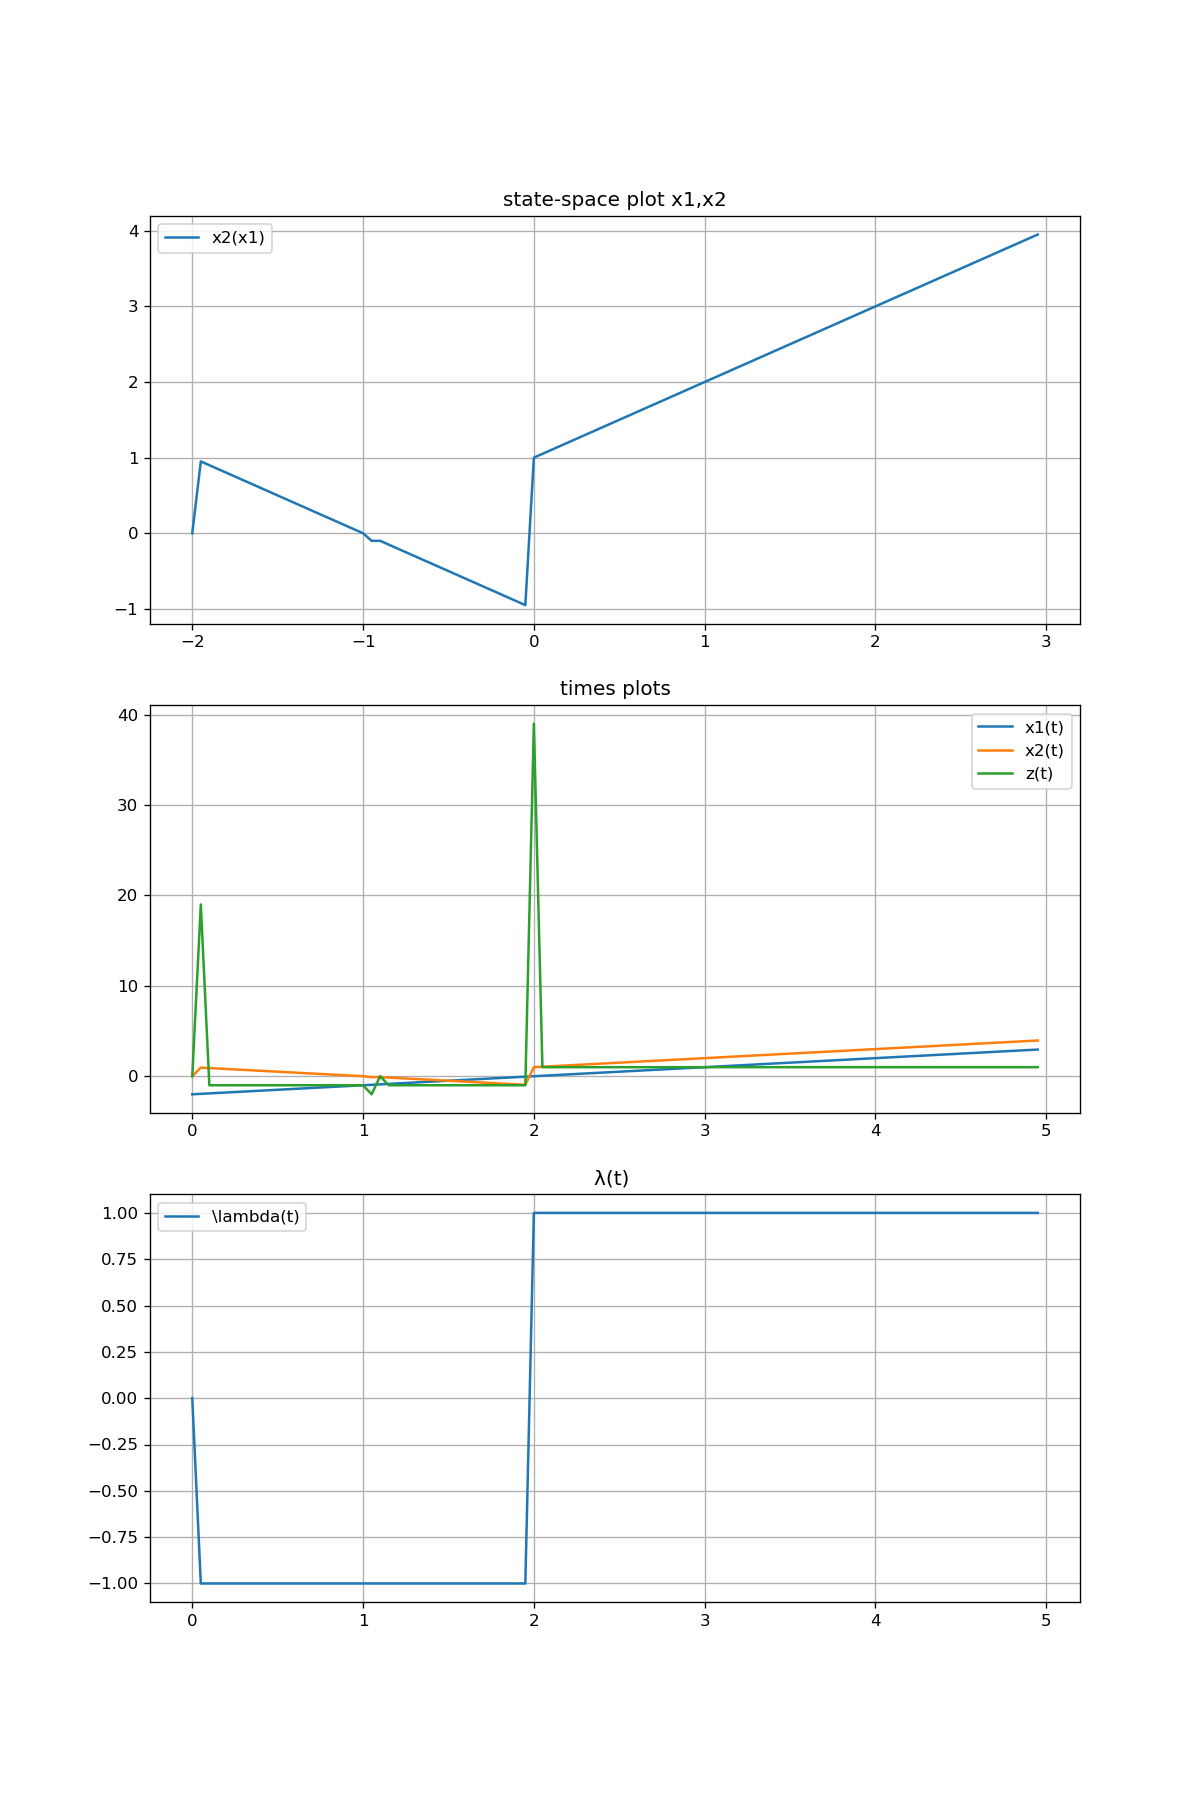

<IPython.core.display.Javascript object>


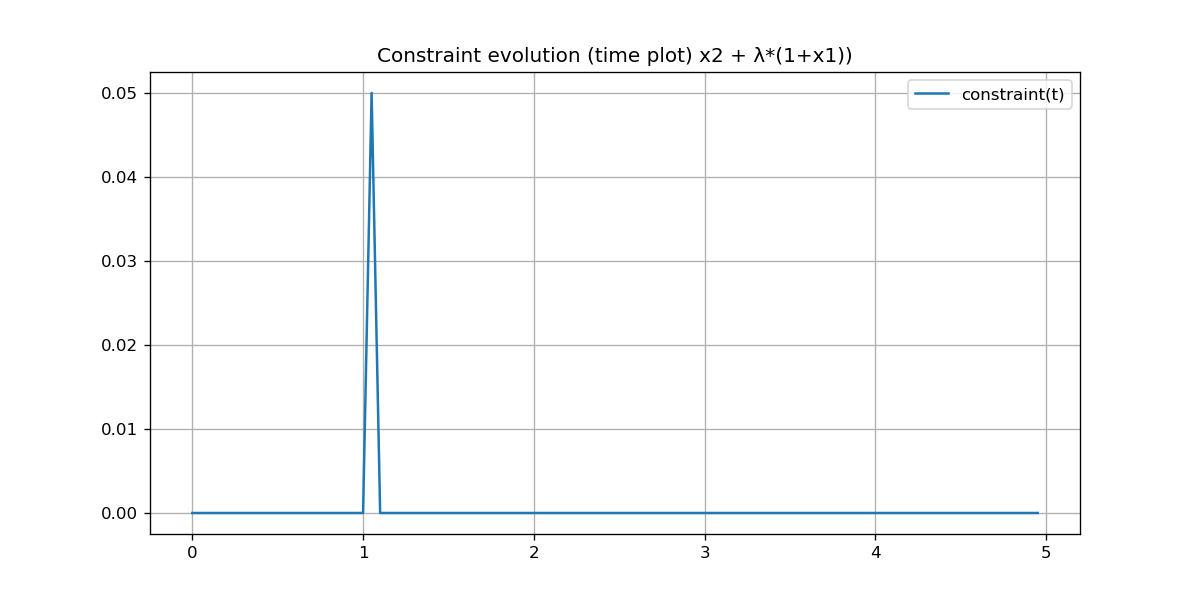

In [4]:
import siconos.numerics as sn
import scipy.linalg as linalg
import numpy as np
import siconos.kernel as sk
from numpy import eye, empty, float64, zeros, transpose, array
from siconos.kernel import FirstOrderLinearTIDS, FirstOrderType2R, FirstOrderLinearTIR, EqualityConditionNSL, RelayNSL,\
                           ComplementarityConditionNSL, NonSmoothDynamicalSystem, Interaction, \
                           EulerMoreauOSI, MoreauJeanOSI, LCP, TimeDiscretisation, TimeStepping 
import siconos.numerics as sn
#import cvxopt 
#from cvxopt import matrix

# Initial conditions
# x10   = -1       
# x20   = 0.1 
z0    = 0 

# x10   = 1.5       
# x20   = 1. 

x10   = -2       
x20   = 0. 

t0    = 0.      # start time
T     = 5      # end time with : 1.6 for start of the pb


# Projection parrallel to the vectorial space spawned by B
# if B = C^T => euclidian norm projection (P=Id)
# Here C is not well defined => B ?
# Let first consider B = [1,0] : no possible solution to project on x2
#     =====> PLUForwardBackwardInPlace solver error during the linear system resolution (Newton discr.)
# _B = [1,0]

# Let now consider B=[0,1]
_B = [0,1]

# Let now consider B=[1,1]
# _B = [1,1]

# constrainte λ*(x1 + 1) = λ(Cx + e)
_C = [1,0]




_A = zeros((3,3))
_A[2,1] = -1
_A[0,2] = _B[0]
_A[1,2] = _B[1]

_b = [1,0,0]

print("A = ")
print(_A)

print("b = ")
print(_b)

_E = np.eye(3)
_E[2,2] = 0
print("E = ")
print(_E)

# Linear ODE system with time invariant coefficients
dyn = FirstOrderLinearTIDS([x10,x20,z0],_A)
dyn.setbPtr(_b)
dyn.setMPtr(_E)

switch = NonSmoothDynamicalSystem(t0, T)
switch.insertDynamicalSystem(dyn)

##################################################################
#     DECLARATION OF The relation and feedback in the Derivatives
#################################################################

# NonLinear-relation wich inherit FirstOrderNonLinearR
# DO NOT FORGET ComputeResiduR and Y when creating TimeStepping pb
class MyNLRelation_SwitchingDAE(sk.FirstOrderNonLinearR):
    
    
    ## Constructeur __init__
    def __init__(self):
        sk.FirstOrderNonLinearR.__init__(self)      
        return
    
    ### h related functions
    # Note that if C is fixed using self.setCPtr() then the output is considered linear
    # and the Jacobian related functions are not used anymore. Same with g.
    # (See sources of computeJach() function ) 
    def computeh(self, time, x, λ, z, y):
        y[:] = zeros(1)
        y[0] = -x[0]; # λ = 0 if x<=0, 1 if x>=0
        pass

    def computeJachlambda(self, time, x, λ, z, D):
        D[:] = zeros((1,1))
        pass
        
    def computeJachx(self, time, x, λ, z, C): 
        C[:] = zeros((1,3))
        C[0,0] = -1 
        pass   
    
    ### g related functions
    def computeg(self, time, x, λ, z, r):      
        r[:] = zeros(3)
        # addition
#         r[1] = λ[0]*x[2]
        #
        r[2] = λ[0]*(_C[0]*x[0] + 1 )
        pass
    
    def computeJacgx(self, time, x, λ, z, K):     
        K[:] = zeros((3,3))
        # addition
#         K[1,2] =  λ[0] 
        #
        K[2,0] =  λ[0]*_C[0]         
        pass
    
    def computeJacglambda(self, time, x, λ, z, B): 
        B[:] = zeros((3,1))
        # addition
#         B[1,0] =  x[2]
        #
        B[2,0] =  _C[0]*x[0]
        pass


### Python Non-linear Relation    
rel_python_1 = MyNLRelation_SwitchingDAE() 
# Declaration that right side is an LCP
nslaw1 = sk.RelayNSL(1,-1.,1.)

# Link between left hand side et right hand side of the LCP
# 0=< C1*x + D1*λ + e1 _|_ λ>= 0
interaction_1 = Interaction(nslaw1, rel_python_1)

##########################################################

switch.link(interaction_1, dyn)

# Discretization and non-smooth problem formulation (LCP)
θ = 1.
γ = 1.
#osi = EulerMoreauOSI(θ)  # One Step time Integrator for First Order Dynamical Systems.
# Simple theta method (~backward euler)
osi = EulerMoreauOSI(θ,γ)  # One Step time Integrator for First Order Dynamical Systems.

osnspb = sk.Relay()


# Simulation and time discretisation
time_step =  0.05
td = TimeDiscretisation(t0, time_step)
simu = TimeStepping(switch, td, osi, osnspb)

##########################################################################
## !!! ALWAYS DECLARE COMPUTE RESIDUY and R for NonLinear Relations !!!!
##         OTHERWISE NEWTOWN ALG DO NOT USE JACOBIANS 
#########################################################################
simu.setComputeResiduY(True)
simu.setComputeResiduR(True)
simu.setNewtonMaxIteration(100)
simu.setNewtonTolerance(1e-10)
##########################################################################



# osnspb.setNumericsVerboseMode(True)
# simu.setWarnOnNonConvergence(True)

##### Simulation run
x = dyn.x() # tracking state variables form ODE
λ = interaction_1.lambda_(0) # tracking λ variables form LCP
k = 0

##### Numpy array used to save data at each time step, for post-processing
N = int((T - t0) / simu.timeStep()) + 1
data_plot = zeros((N, 5))

###### Initial state
data_plot[k, 0] = t0
data_plot[k, 1] = x[0] # x1
data_plot[k, 2] = x[1] # x2
data_plot[k, 3] = x[2] # z
data_plot[k, 4] = λ[0] # λ
k += 1

while simu.hasNextEvent():
    
    simu.computeOneStep() # Build and solve the LCP    
    #osnspb.display()
    data_plot[k, 0] = simu.nextTime()
    data_plot[k, 1] = x[0] # x1
    data_plot[k, 2] = x[1] # x2
    data_plot[k, 3] = x[2] # z
    data_plot[k, 4] = λ[0] # λ
    k += 1 
    #rel_python.display()
    simu.nextStep() # Save current state and prepare next step

#osnspb.display()
#np.linalg.eigvals(_M)
print(k)

import ipympl
import matplotlib.pyplot as plt
%matplotlib notebook

plt.figure(figsize=(10,15))
plt.subplot(311)
plt.title('state-space plot x1,x2')
plt.plot(data_plot[0:k - 1, 1], data_plot[0:k - 1, 2],label='x2(x1)')
plt.legend()
plt.grid()
plt.subplot(312)
plt.title('times plots')
plt.plot(data_plot[0:k - 1, 0], data_plot[0:k - 1, 1],label='x1(t)')
plt.plot(data_plot[0:k - 1, 0], data_plot[0:k - 1, 2],label='x2(t)')
plt.plot(data_plot[0:k - 1, 0], data_plot[0:k - 1, 3],label='z(t)')
plt.legend()
plt.grid()
plt.subplot(313)
plt.title('λ(t) ')
plt.plot(data_plot[0:k - 1, 0], data_plot[0:k - 1, 4],label='\lambda(t)')
plt.legend()
plt.grid()
plt.show()

constraint = -data_plot[0:k - 1, 2] + data_plot[0:k - 1, 4]*(1 + data_plot[0:k - 1, 1]) 

plt.figure(figsize=(10,5))
plt.title('Constraint evolution (time plot) x2 + λ*(1+x1))')
plt.plot(data_plot[0:k - 1, 0], constraint,label='constraint(t)')
plt.legend()
plt.grid()
plt.show()